In [2]:
import os 
os.environ['TP_CPP_MIN_LOG_LEVEL'] = '2'
import math
import random
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## I. Data Generation

In [3]:
BASE_DIR = 'data/star-wars-images/'
names = ['YODA', 'LUKE SKYWALKER', 'R2-D2', 'MACE WINDU', 'GENERAL GRIEVOUS']
tf.random.set_seed(1)

In [4]:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

In [6]:
orig_folders = ['0001/', '0002/', '0003/', '0004/', '0005/']
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images *0.6) + 0.5)
    n_valid = int((number_of_images *0.25) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)

    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + 'train/' + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + 'val/' + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + 'test/' + names[folder_idx])


12 7 3 2
12 7 3 2
12 7 3 2
13 8 3 2
14 8 4 2


## II. Prepare Data

In [7]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batches = train_gen.flow_from_directory(
    'data/star-wars-images/train',
    target_size = (256, 256),
    class_mode = 'sparse', 
    batch_size = 4,
    shuffle=True, 
    color_mode = 'rgb',
    classes = names
)

val_batches = train_gen.flow_from_directory(
    'data/star-wars-images/val',
    target_size = (256, 256),
    class_mode = 'sparse', 
    batch_size = 4,
    shuffle=False, 
    color_mode = 'rgb',
    classes = names
)

test_batches = train_gen.flow_from_directory(
    'data/star-wars-images/test',
    target_size = (256, 256),
    class_mode = 'sparse', 
    batch_size = 4,
    shuffle=False, 
    color_mode = 'rgb',
    classes = names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [8]:
train_batch = train_batches[0]
print(train_batch[0].shape)
print(train_batch[1])

test_batch = test_batches[0]
print(test_batch[0].shape)
print(test_batch[1])

(4, 256, 256, 3)
[4. 2. 3. 1.]
(4, 256, 256, 3)
[0. 0. 1. 1.]


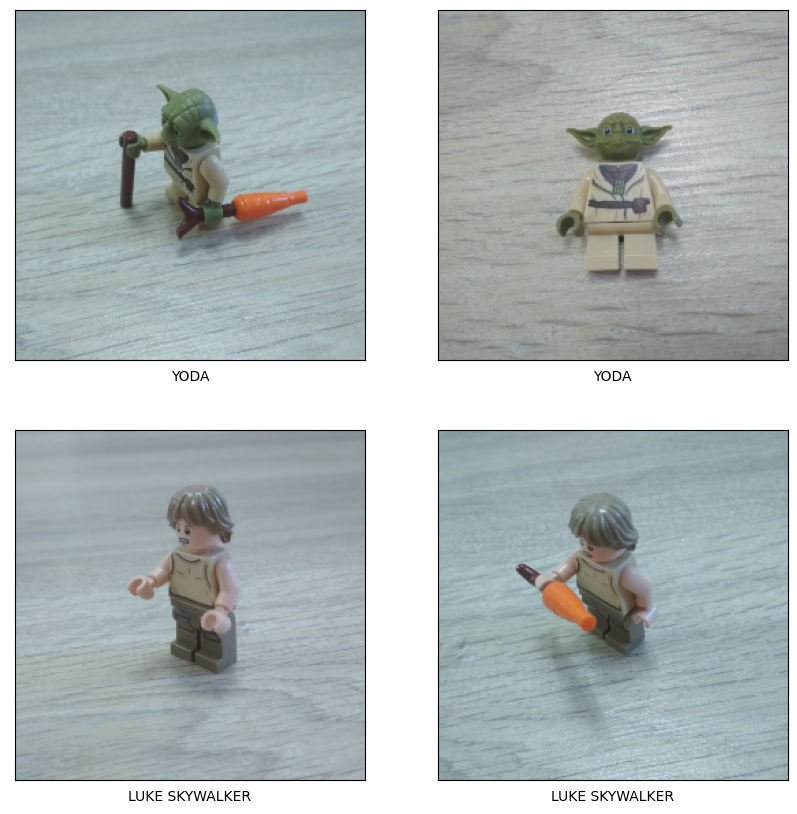

In [9]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.binary)

        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show()

show(test_batch)

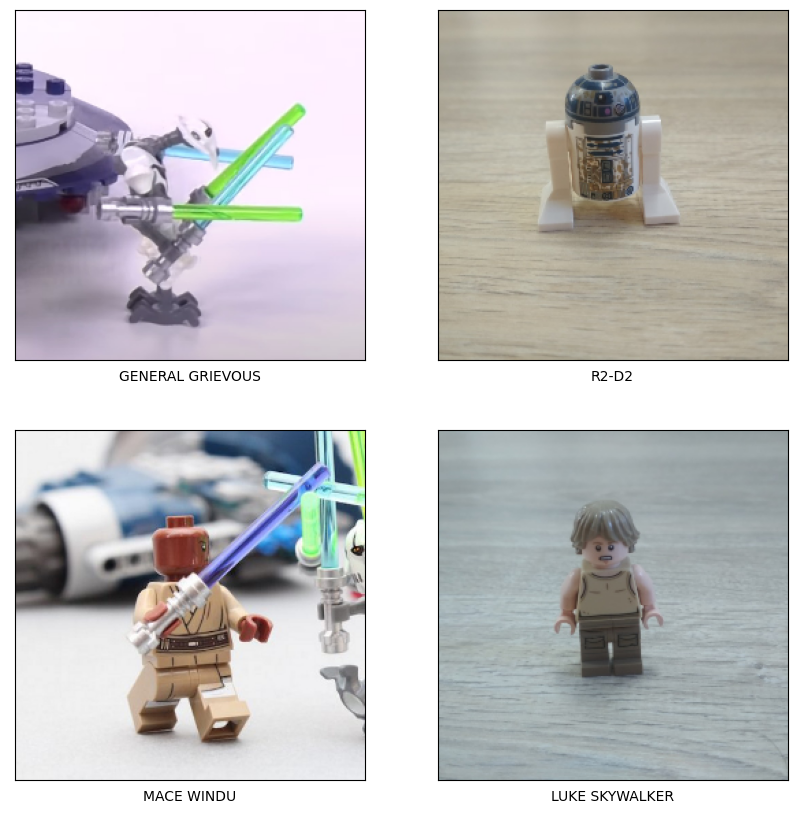

In [10]:
show(train_batch)

## III. Model

In [12]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 64)               

In [13]:
# loss and optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['Accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#### III. a) Training

In [31]:
epochs = 50

history = model.fit(x=train_batches, validation_data = val_batches, epochs=epochs, verbose=1)

Epoch 1/50
10/10 [==============================] - 5s 471ms/step - loss: 1.6094 - Accuracy: 0.2162 - val_loss: 1.6094 - val_Accuracy: 0.2500
Epoch 2/50
10/10 [==============================] - 5s 480ms/step - loss: 1.6094 - Accuracy: 0.2162 - val_loss: 1.6094 - val_Accuracy: 0.2500
Epoch 3/50
10/10 [==============================] - 6s 558ms/step - loss: 1.6094 - Accuracy: 0.2162 - val_loss: 1.6094 - val_Accuracy: 0.2500
Epoch 4/50
10/10 [==============================] - 6s 631ms/step - loss: 1.6094 - Accuracy: 0.2162 - val_loss: 1.6094 - val_Accuracy: 0.2500
Epoch 5/50
10/10 [==============================] - 5s 476ms/step - loss: 1.6094 - Accuracy: 0.2162 - val_loss: 1.6094 - val_Accuracy: 0.2500
Epoch 6/50
10/10 [==============================] - 5s 466ms/step - loss: 1.6094 - Accuracy: 0.2162 - val_loss: 1.6094 - val_Accuracy: 0.2500
Epoch 7/50
10/10 [==============================] - 5s 477ms/step - loss: 1.6094 - Accuracy: 0.2162 - val_loss: 1.6094 - val_Accuracy: 0.2500
Epoch 

In [18]:
model.save('lego_model.h5')

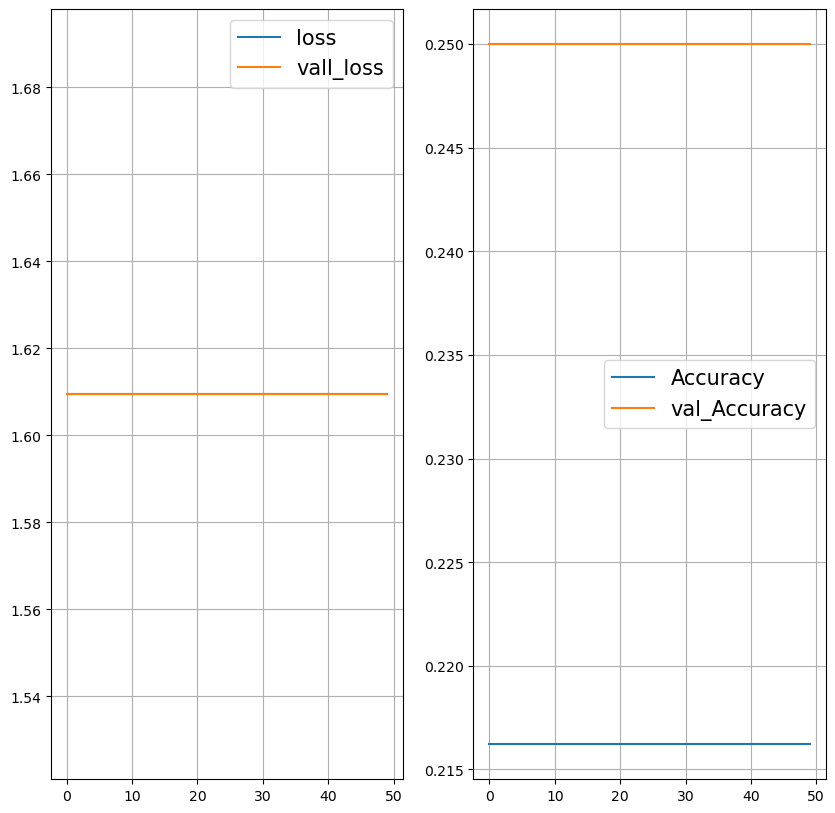

In [32]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='vall_loss')
plt.legend(fontsize=15)
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['Accuracy'], label='Accuracy')
plt.plot(history.history['val_Accuracy'], label='val_Accuracy')
plt.legend(fontsize=15)
plt.grid()

## IV: Evaluation

In [28]:
model.evaluate(test_batches, verbose=1)

3/3 [==============================] - 0s 80ms/step - loss: 1.6094 - Accuracy: 0.2000


[1.6094379425048828, 0.20000000298023224]

In [29]:
predictions = model.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

3/3 [==============================] - 1s 110ms/step
[0. 0. 1. 1.]
[4 4 4 4]


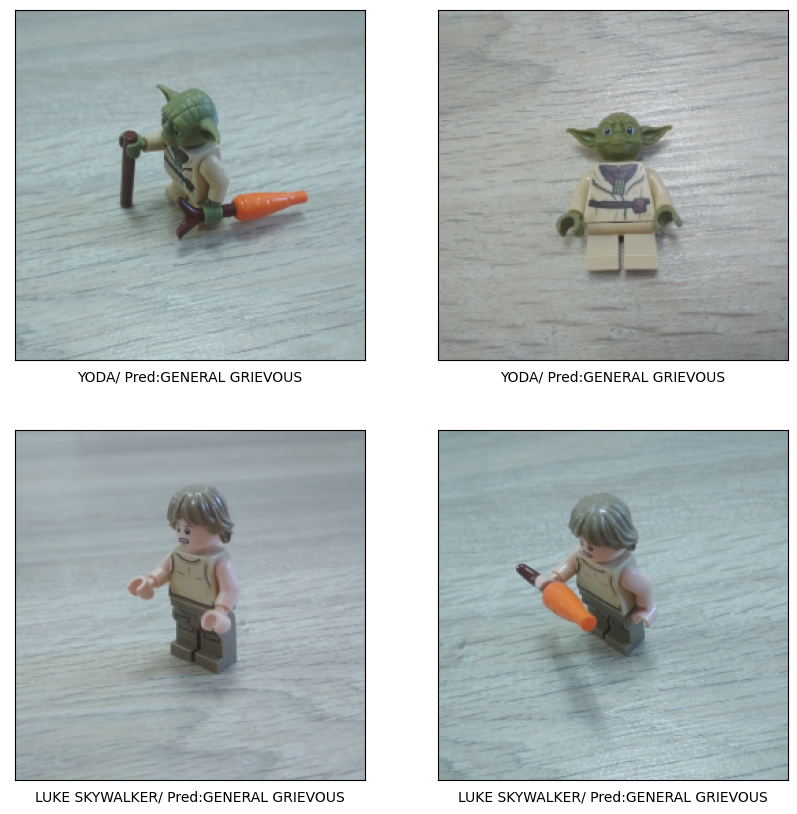

In [30]:
show(test_batches[0], labels[0:4])